# Features

## Use `dataloader` to get an utterance

In [1]:
from dataloader import get_dataloader
import torch
import numpy as np

# CTC model for ASR

## Obtain phoneme output units

In [2]:
# First find the unique phones in train.json, and then
# create a file named vocab.txt, each line in this 
# file is a unique phone, in total there should be 
# 40 lines

vocab = {}
phonemes = []
with open("vocab_39.txt") as f:
    for id, text in enumerate(f):
        vocab[text.strip()] = id
        phonemes.append(text)
phonemes = phonemes[1:]

## Model & training configurations

In [3]:
from collections import namedtuple
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

args = {'seed': 123,
        'train_json': 'train_fbank.json',
        'val_json': 'dev_fbank.json',
        'test_json': 'test_fbank.json',
        'batch_size': 4,
        'num_layers': 2,
        'fbank_dims': 23,
        'model_dims': 128,
        'concat': 1,
        'lr': 0.5,
        'vocab': vocab,
        'report_interval': 50,
        'dropout': 0.3,
        'num_epochs': 20,
        'device': device,
        'optimiser': 'sgd',
        'grad_clip': 0.5
       }

args = namedtuple('x', args)(**args)

In [4]:
import models
model = models.BiLSTM(
    args.num_layers, args.fbank_dims * args.concat, args.model_dims, len(args.vocab), dropout=args.dropout, 
)
num_params = sum(p.numel() for p in model.parameters())
print('Total number of model parameters is {}'.format(num_params))

Total number of model parameters is 562216


## Training

In [5]:
# from datetime import datetime
# from trainer import train
# start = datetime.now()
# model.to(args.device)
# model_path = train(model, args)
# end = datetime.now()
# duration = (end - start).total_seconds()
# print('Training finished in {} minutes.'.format(divmod(duration, 60)[0]))
# print('Model saved to {}'.format(model_path))

## Decoding

In [6]:
## You can uncomment the following line and change model path to the model you want to decode
model_path="checkpoints/20231207_193515/model_20"

In [7]:
import torch
print('Loading model from {}'.format(model_path))
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

Loading model from checkpoints/20231207_193515/model_20


FileNotFoundError: [Errno 2] No such file or directory: 'checkpoints/20231207_193515/model_20'

In [ ]:
import json
single_utt = {
    "MDAB0_SI1669.WAV": {"duration": 2.0608125, 
                         "phn": "sil b iy ih sil k s ay dx ih sil d ih n sil d ow n ah sil d eh n ah f ay er s eh l f sil", 
                         "spk_id": "MDAB0", "fbank": "/rds/user/ejg84/hpc-work/MLMI2/TIMIT/data/fbanks/test/MDAB0/SI1669.WAV"
                        }
}
with open('single_utt.json', 'w+') as f:
    json.dump(single_utt, f)

## 3.2.1

In [ ]:
# decode script - vis

from jiwer import compute_measures, cer
import torch

from dataloader import get_dataloader
from utils import concat_inputs

def decode(model, args, json_file, char=False):
    struct_for_heatmap = None
    idx2grapheme = {y: x for x, y in args.vocab.items()}
    test_loader = get_dataloader(json_file, 1, False)
    stats = [0., 0., 0., 0.]
    for data in test_loader:
        inputs, in_lens, trans, _ = data
        inputs = inputs.to(args.device)
        in_lens = in_lens.to(args.device)
        inputs, in_lens = concat_inputs(inputs, in_lens, factor=args.concat)
        with torch.no_grad():
            outputs = torch.nn.functional.softmax(model(inputs), dim=-1)
            struct_for_heatmap = outputs
            outputs = torch.argmax(outputs, dim=-1).transpose(0, 1)
            print(outputs)
#         print(outputs)
#         print(outputs.shape)
        outputs = [[idx2grapheme[i] for i in j] for j in outputs.tolist()]
        outputs = [[v for i, v in enumerate(j) if i == 0 or v != j[i - 1]] for j in outputs]
        outputs = [list(filter(lambda elem: elem != "_", i)) for i in outputs]
        outputs = [" ".join(i) for i in outputs]
        print(outputs)
        
    return struct_for_heatmap


In [ ]:
results = decode(model, args, 'single_utt.json')
# print("SUB: {:.2f}%, DEL: {:.2f}%, INS: {:.2f}%, COR: {:.2f}%, PER: {:.2f}%".format(*results))
results

In [ ]:
# plot heatmap
data_to_plot = results[5:25]
data_to_plot.shape

In [ ]:
import torch
import matplotlib.pyplot as plt

# Squeeze the tensor to remove the singleton dimension (1)
tensor_squeezed = torch.transpose(data_to_plot.squeeze(),0,1)

# Convert the tensor to a NumPy array
tensor_numpy = tensor_squeezed.numpy()

# Plotting the heatmap
plt.figure(figsize=(10,5))
plt.imshow(tensor_numpy, cmap='YlOrRd', aspect='auto')
plt.colorbar(label='Probability')
plt.xlabel('Frames')
plt.ylabel('Phones')
y_labels = ['-'] + list(args.vocab.keys())[1:]
plt.yticks(np.arange(len(args.vocab)), y_labels, fontsize=8)
plt.show()


# 3.2.2

In [ ]:
# decode script - blank penalty

from jiwer import compute_measures, cer
import torch

from dataloader import get_dataloader
from utils import concat_inputs

bp = 0.8

def decode(model, args, json_file, char=False):
    idx2grapheme = {y: x for x, y in args.vocab.items()}
    test_loader = get_dataloader(json_file, 1, False)
    stats = [0., 0., 0., 0.]
    for data in test_loader:
        inputs, in_lens, trans, _ = data
        inputs = inputs.to(args.device)
        in_lens = in_lens.to(args.device)
        inputs, in_lens = concat_inputs(inputs, in_lens, factor=args.concat)
        with torch.no_grad():
            outputs = torch.nn.functional.softmax(model(inputs), dim=-1)

            # apply blank penalty
            outputs[:,0,0] -= (bp*outputs[:,0,0])
            outputs = torch.argmax(outputs, dim=-1).transpose(0, 1)
            
        outputs = [[idx2grapheme[i] for i in j] for j in outputs.tolist()]
        outputs = [[v for i, v in enumerate(j) if i == 0 or v != j[i - 1]] for j in outputs]
        outputs = [list(filter(lambda elem: elem != "_", i)) for i in outputs]
        outputs = [" ".join(i) for i in outputs]
        for out in outputs:
            if out != trans:
                print(out)
                print(trans[0]+'\n')

        if '61'in args.vocab:
            outputs = [" ".join(map_to_39(i)) for i in outputs]

        if char:
            cur_stats = cer(trans, outputs, return_dict=True)
        else:
            cur_stats = compute_measures(trans, outputs)
        stats[0] += cur_stats["substitutions"]
        stats[1] += cur_stats["deletions"]
        stats[2] += cur_stats["insertions"]
        stats[3] += cur_stats["hits"]

    total_words = stats[0] + stats[1] + stats[3]
    sub = stats[0] / total_words * 100
    dele = stats[1] / total_words * 100
    ins = stats[2] / total_words * 100
    cor = stats[3] / total_words * 100
    err = (stats[0] + stats[1] + stats[2]) / total_words * 100
    return sub, dele, ins, cor, err

In [ ]:
results = decode(model, args, args.test_json)

In [ ]:
# 0.1
print("SUB: {:.2f}%, DEL: {:.2f}%, INS: {:.2f}%, COR: {:.2f}%, PER: {:.2f}%".format(*results))

In [ ]:
# 0.5
print("SUB: {:.2f}%, DEL: {:.2f}%, INS: {:.2f}%, COR: {:.2f}%, PER: {:.2f}%".format(*results))

In [ ]:
# 0.8
print("SUB: {:.2f}%, DEL: {:.2f}%, INS: {:.2f}%, COR: {:.2f}%, PER: {:.2f}%".format(*results))

In [ ]:
# find a good example

## 3.2.3

In [ ]:
# First find the unique phones in train.json, and then
# create a file named vocab.txt, each line in this 
# file is a unique phone, in total there should be 
# 40 lines

vocab = {}
phonemes = []
with open("vocab_61.txt") as f:
    for id, text in enumerate(f):
        vocab[text.strip()] = id
        phonemes.append(text)
phonemes = phonemes[1:]
vocab

In [ ]:
from collections import namedtuple
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

copy_args = {'seed': 123,
        'train_json': 'train_fbank61.json',
        'val_json': 'dev_fbank.json',
        'test_json': 'test_fbank.json',
        'batch_size': 4,
        'num_layers': 2,
        'fbank_dims': 23,
        'model_dims': 128,
        'concat': 1,
        'lr': 0.5,
        'vocab': vocab,
        'report_interval': 50,
        'dropout': 0.3,
        'num_epochs': 20,
        'device': device,
        'optimiser': 'sgd',
        'grad_clip': 0.5
       }

copy_args = namedtuple('y', copy_args)(**copy_args)

In [ ]:
import models
model = models.BiLSTM(
    copy_args.num_layers, copy_args.fbank_dims * copy_args.concat, 
    copy_args.model_dims, len(copy_args.vocab), dropout=copy_args.dropout
)
num_params = sum(p.numel() for p in model.parameters())
print('Total number of model parameters is {}'.format(num_params))

In [ ]:
import torch
model_path="checkpoints/20231209_162647/model_6"
print('Loading model from {}'.format(model_path))
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

In [ ]:
# decode script - full phn set

from jiwer import compute_measures, cer
import torch

from dataloader import get_dataloader
from utils import concat_inputs

# build global phone map
phone_map = {}

with open('phone_map') as f:
    lines = f.readlines()
    for line in lines:
        line_split = line.split(':')
        orig_phn = line_split[0]
        mapped_39_phn = line_split[1]
        phone_map[orig_phn] = mapped_39_phn.strip('\n')

def map_to_39(phns):
    mapped_phns = []
    for phn in phns[0].split():
        mapped_phn = phone_map[phn]
        mapped_phns.append(mapped_phn.strip())
    return [" ".join(mapped_phns)]

def decode(model, args, json_file, char=False):
    idx2grapheme = {y: x for x, y in args.vocab.items()}
    test_loader = get_dataloader(json_file, 1, False)
    stats = [0., 0., 0., 0.]
    for data in test_loader:
        inputs, in_lens, trans, _ = data
        inputs = inputs.to(args.device)
        in_lens = in_lens.to(args.device)
        inputs, in_lens = concat_inputs(inputs, in_lens, factor=args.concat)
        with torch.no_grad():
            outputs = torch.nn.functional.softmax(model(inputs), dim=-1)
            outputs = torch.argmax(outputs, dim=-1).transpose(0, 1)
        outputs = [[idx2grapheme[i] for i in j] for j in outputs.tolist()]
        outputs = [[v for i, v in enumerate(j) if i == 0 or v != j[i - 1]] for j in outputs]
        outputs = [list(filter(lambda elem: elem != "_", i)) for i in outputs]
        outputs = [" ".join(i) for i in outputs]

        if args.train_json == 'train_fbank61.json':
            print(f'old outputs are: {outputs}')
            outputs = map_to_39(outputs)
            print(f'need to map phones: {outputs}')

        if char:
            cur_stats = cer(trans, outputs, return_dict=True)
        else:
            cur_stats = compute_measures(trans, outputs)
        stats[0] += cur_stats["substitutions"]
        stats[1] += cur_stats["deletions"]
        stats[2] += cur_stats["insertions"]
        stats[3] += cur_stats["hits"]

    total_words = stats[0] + stats[1] + stats[3]
    sub = stats[0] / total_words * 100
    dele = stats[1] / total_words * 100
    ins = stats[2] / total_words * 100
    cor = stats[3] / total_words * 100
    err = (stats[0] + stats[1] + stats[2]) / total_words * 100
    return sub, dele, ins, cor, err

# test = 'sil dh iy ih sil s k oy tcl ih sil d ih n sil d ow n ah sil d eh n ah f ay er s eh el f sil'.split()
# print(phone_map)
# print(map_to_39(test))

In [ ]:
results = decode(model, copy_args, copy_args.test_json)
print("SUB: {:.2f}%, DEL: {:.2f}%, INS: {:.2f}%, COR: {:.2f}%, PER: {:.2f}%".format(*results))

## 3.2.4

In [ ]:
# decode script - confusion

from jiwer import compute_measures, cer
import torch

from dataloader import get_dataloader
from utils import concat_inputs

def decode(model, args, json_file, char=False):
    idx2grapheme = {y: x for x, y in args.vocab.items()}
    test_loader = get_dataloader(json_file, 1, False)
    stats = [0., 0., 0., 0.]
    predictions = []
    ground_truth = []
    for data in test_loader:
        inputs, in_lens, trans, _ = data
        ground_truth.append(trans[0].split())
        inputs = inputs.to(args.device)
        in_lens = in_lens.to(args.device)
        inputs, in_lens = concat_inputs(inputs, in_lens, factor=args.concat)
        with torch.no_grad():
            outputs = torch.nn.functional.softmax(model(inputs), dim=-1)
            outputs = torch.argmax(outputs, dim=-1).transpose(0, 1)
        outputs = [[idx2grapheme[i] for i in j] for j in outputs.tolist()]
        outputs = [[v for i, v in enumerate(j) if i == 0 or v != j[i - 1]] for j in outputs]
        outputs = [list(filter(lambda elem: elem != "_", i)) for i in outputs]
#         outputs = [" ".join(i) for i in outputs]
        predictions.append(outputs[0])
        
    return predictions, ground_truth

In [ ]:
predictions, ground_truth = decode(model, args, args.test_json)

In [ ]:
print(predictions[0])
print(ground_truth[0])

In [ ]:
import Levenshtein
import numpy as np

V = 41
vocab = []

with open('vocab_39.txt') as f:
    lines = f.readlines()
    for phn in lines:
        vocab.append(phn.strip('\n'))

def compute_confusion(predictions, ground_truth):
    C = np.zeros(V*V).reshape(V,V)
    for pred, gt in zip(predictions, ground_truth):
        ops = Levenshtein.editops(pred, gt)
        indices_affected = []
        for op, pos_p, pos_gt in ops: 
            indices_affected.append(pos_p)

        for op, pos_p, pos_gt in ops: 
            if pos_p == len(pred):
                continue
            gt_phn_idx = vocab.index(gt[pos_gt])
            p_phn_idx = vocab.index(pred[pos_p])

            if op == 'insert':
                C[:,-1][p_phn_idx] += 1
            elif op == 'delete':
                C[-1][p_phn_idx] += 1
            elif op == 'replace':
                C[gt_phn_idx][p_phn_idx] += 1
                C[p_phn_idx][gt_phn_idx] += 1
            else:
                print(f'op {op} is not considered in our case')
        
        for i in range(len(pred)):
            if i not in indices_affected:
                curr_count = C[vocab.index(pred[i])][vocab.index(pred[i])]
                if curr_count < 100:
                    C[vocab.index(pred[i])][vocab.index(pred[i])] += 1
              
    return C

In [ ]:
# compute confusion matrix
C = compute_confusion(predictions,ground_truth)
C   

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.imshow(C)
plt.colorbar()
tick_labels = ['-'] + list(args.vocab.keys())[1:]
plt.yticks(np.arange(len(args.vocab)), tick_labels, fontsize=8)
plt.xticks(np.arange(len(args.vocab)), tick_labels, fontsize=8)

In [ ]:
print(vocab[28], vocab[17])

## Plotting

<Figure size 1000x500 with 0 Axes>

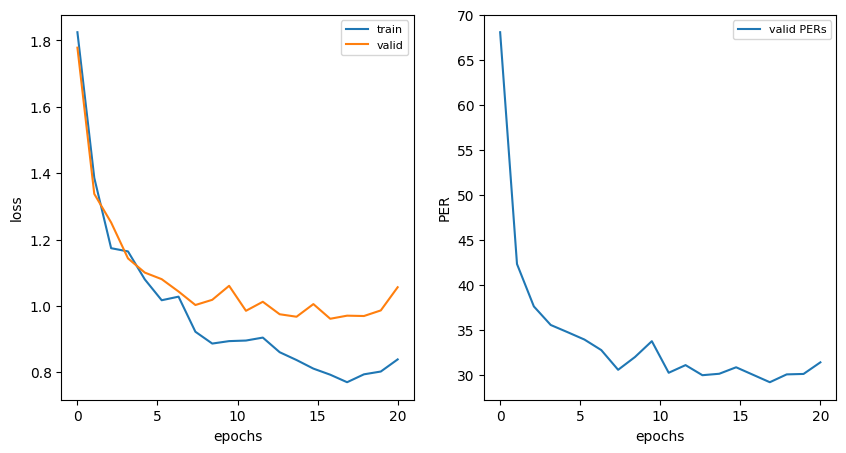

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# init
plt.figure(figsize=(10,5))

train_loss = [
    1.82474,
1.38592,
1.17388,
1.16418,
1.07972,
1.01704,
1.02782,
0.92208,
0.88646,
0.89385,
0.89556,
0.90447,
0.86040,
0.83687,
0.81099,
0.79263,
0.76997,
0.79377,
0.80220,
0.83875,
]
    
valid_loss =    [
        1.77826,
1.33755,
1.25135,
1.14313,
1.10031,
1.08053,
1.04334,
1.00266,
1.01832,
1.06050,
0.98522,
1.01243,
0.97481,
0.96733,
1.00541,
0.96122,
0.97055,
0.96949,
0.98636,
1.05625,
    ]

pers = [68.06, 42.31, 37.6, 35.54, 34.74, 33.92, 32.75, 30.56, 31.98, 33.74, 30.23, 31.08, 29.96, 30.12, 30.84, 30.01, 29.18, 30.05, 30.1, 31.39]

xs = np.linspace(0,20,20)

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(xs,train_loss, label='train')
ax[0].plot(xs,valid_loss, label='valid')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('loss')

ax[0].legend(fontsize=8)

ax[1].plot(xs,pers, label='valid PERs')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('PER')
ax[1].legend(fontsize=8)
plt.show()

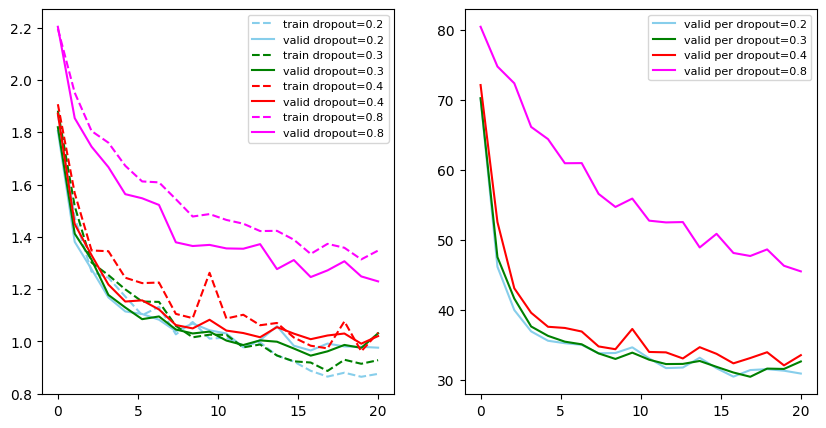

In [14]:
# q3.1.1 - reg - dropout
train_loss_20 = [
    1.86805,
1.47527,
1.26675,
1.24319,
1.17146,
1.10004,
1.13229,
1.02676,
1.07397,
1.01060,
1.01382,
0.98401,
0.99593,
0.94578,
0.92273,
0.88728,
0.86514,
0.88004,
0.86452,
0.87569,
]

valid_loss_20 = [
    1.80462,
1.38076,
1.27571,
1.16804,
1.11448,
1.10466,
1.08286,
1.03901,
1.06836,
1.04229,
1.03012,
0.97719,
1.00453,
1.05816,
0.98343,
0.96508,
0.99153,
0.98056,
0.97907,
0.97579,
]

valid_loss_40 = [
    1.87132,
1.44844,
1.32950,
1.21715,
1.15236,
1.15691,
1.12203,
1.06235,
1.04955,
1.08263,
1.04120,
1.03185,
1.01577,
1.05450,
1.02959,
1.00825,
1.02248,
1.03002,
0.99114,
1.02020,
]

train_loss_40 = [
    1.90710,
1.56695,
1.34766,
1.34472,
1.24340,
1.22281,
1.22502,
1.10505,
1.08880,
1.26224,
1.08744,
1.10180,
1.06166,
1.07035,
1.01475,
0.98333,
0.97323,
1.07628,
0.96197,
1.03284,
]

train_loss_30 = [
    1.88246,
1.51682,
1.30135,
1.25341,
1.19891,
1.15223,
1.15098,
1.05921,
1.01545,
1.02550,
1.02493,
0.97692,
0.98803,
0.94588,
0.92356,
0.91904,
0.88681,
0.92968,
0.91426,
0.92803,
]

valid_loss_30 = [
 1.81916,
1.41190,
1.31249,
1.17745,
1.12955,
1.08487,
1.09530,
1.04539,
1.03023,
1.03720,
1.00306,
0.98592,
1.00378,
0.99864,
0.97260,
0.94539,
0.96188,
0.98630,
0.97516,
1.03088,   
]


train_loss_80 = [
    2.19590,
1.95108,
1.80447,
1.75987,
1.67162,
1.61176,
1.60819,
1.54393,
1.47756,
1.48682,
1.46443,
1.45013,
1.42194,
1.42271,
1.38896,
1.33448,
1.37300,
1.35801,
1.31358,
1.34733,
]

valid_loss_80 = [
    2.20331,
1.85385,
1.74465,
1.66643,
1.56301,
1.54731,
1.52184,
1.37887,
1.36469,
1.36899,
1.35550,
1.35432,
1.37186,
1.27634,
1.31106,
1.24594,
1.27151,
1.30640,
1.24841,
1.22941,
]

PERs_1 = [70.24, 46.19, 40.0, 36.95, 35.61, 35.26, 35.03, 33.82, 33.86, 34.67, 33.09, 31.7, 31.78, 33.18, 31.68, 30.48, 31.42, 31.55, 31.33, 30.92]
PERs_2 = [70.29, 47.57, 41.64, 37.65, 36.31, 35.48, 35.1, 33.8, 33.01, 33.91, 32.9, 32.28, 32.3, 32.72, 31.88, 31.07, 30.46, 31.63, 31.58, 32.65]
PERs_3 = [72.17, 52.58, 43.11, 39.61, 37.61, 37.44, 36.93, 34.8, 34.4, 37.3, 34.01, 33.95, 33.08, 34.69, 33.74, 32.38, 33.14, 33.97, 32.09, 33.55]
PERs_4 = [80.5, 74.82, 72.42, 66.18, 64.44, 60.99, 61.01, 56.61, 54.74, 55.94, 52.78, 52.53, 52.58, 48.95, 50.9, 48.16, 47.73, 48.67, 46.33, 45.53]

fig, ax = plt.subplots(1,2, figsize=(10,5))


# plt.figure(figsize=(10,5))
xs = np.linspace(0,20,20)
ax[0].plot(xs,train_loss_20, label='train dropout=0.2', c='skyblue', linestyle='--')
ax[0].plot(xs,valid_loss_20, label='valid dropout=0.2', c='skyblue')

ax[0].plot(xs,train_loss_30, label='train dropout=0.3', c='g', linestyle='--')
ax[0].plot(xs,valid_loss_30, label='valid dropout=0.3', c='g')

ax[0].plot(xs,train_loss_40, label='train dropout=0.4', c='r', linestyle='--')
ax[0].plot(xs,valid_loss_40, label='valid dropout=0.4', c='r')

ax[0].plot(xs,train_loss_80, label='train dropout=0.8', c='magenta', linestyle='--')
ax[0].plot(xs,valid_loss_80, label='valid dropout=0.8', c='magenta')

ax[0].legend(fontsize=8)

ax[1].plot(xs,PERs_1, label='valid PER dropout=0.2', c='skyblue')
ax[1].plot(xs,PERs_2, label='valid PER dropout=0.3', c='g')
ax[1].plot(xs,PERs_3, label='valid PER dropout=0.4', c='r')
ax[1].plot(xs,PERs_4, label='valid PER dropout=0.8', c='magenta')

ax[1].legend(fontsize=8)

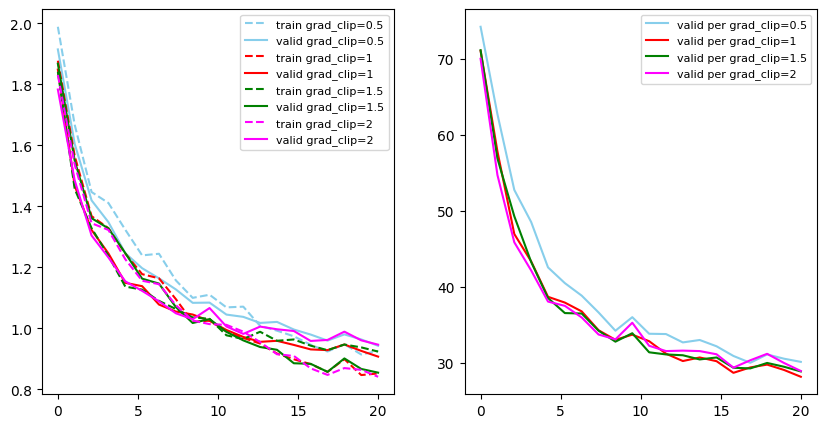

In [30]:
# q3.1.1 - reg - clip
#0.5
train_loss_1 = [1.9889, 1.66758, 1.4473, 1.41128, 1.32369, 1.23954, 1.24486, 1.15765, 1.10034, 1.11052, 1.06909, 1.07147, 1.00849, 0.99271, 0.97434, 0.94658, 0.92442, 0.94838, 0.91461, 0.92632]
valid_loss_1 = [1.91471, 1.60505, 1.41994, 1.34848, 1.24671, 1.19746, 1.16424, 1.128, 1.084, 1.0847, 1.0455, 1.03801, 1.01811, 1.02145, 0.99657, 0.97996, 0.96021, 0.98052, 0.964, 0.94321]

# 1
train_loss_2 = [1.87762, 1.56542, 1.36814, 1.32874, 1.24564, 1.17804, 1.16434, 1.09621, 1.02114, 1.02578, 0.99015, 0.96892, 0.95048, 0.91777, 0.89896, 0.88313, 0.85758, 0.89938, 0.84725, 0.85252]
valid_loss_2 = [1.84849, 1.46736, 1.32283, 1.2459, 1.14954, 1.13855, 1.07838, 1.0554, 1.0456, 1.0249, 0.99506, 0.97219, 0.95617, 0.9595, 0.94601, 0.93135, 0.92893, 0.94749, 0.92646, 0.90769]

# 1.5
valid_loss_3 = [1.86806, 1.54992, 1.36138, 1.32811, 1.24697, 1.16322, 1.14702, 1.07014, 1.01788, 1.03076, 0.989, 0.96089, 0.93918, 0.93004, 0.88593, 0.88404, 0.85775, 0.90174, 0.86727, 0.85515]
train_loss_3 = [1.84162, 1.45706, 1.32865, 1.23845, 1.13725, 1.12722, 1.09042, 1.06377, 1.03609, 1.03158, 0.97763, 0.96543, 0.98913, 0.95963, 0.96386, 0.94364, 0.92868, 0.94733, 0.93793, 0.9242]

# 2
train_loss_4 = [1.83105, 1.53675, 1.34497, 1.32292, 1.2269, 1.15648, 1.14513, 1.07641, 1.02587, 1.01423, 1.01185, 0.98957, 0.95532, 0.91546, 0.90985, 0.86916, 0.84777, 0.87012, 0.86432, 0.8416]
valid_loss_4 = [1.78322, 1.48514, 1.30476, 1.2326, 1.1545, 1.12316, 1.08908, 1.04974, 1.03023, 1.06688, 1.00638, 0.98221, 1.00608, 0.99734, 0.99165, 0.95902, 0.96238, 0.98951, 0.96102, 0.94685]

pers_1 =  [74.22, 62.72, 52.76, 48.54, 42.57, 40.5, 38.85, 36.64, 34.24, 36.02, 33.84, 33.8, 32.7, 33.02, 32.19, 30.92, 30.02, 31.12, 30.56, 30.14]
pers_2 = [71.06, 57.82, 46.96, 43.36, 38.7, 37.94, 36.78, 34.3, 33.04, 33.72, 32.86, 31.22, 30.25, 30.72, 30.23, 28.7, 29.41, 29.78, 29.08, 28.18]
pers_3 = [71.14, 56.9, 49.3, 43.29, 38.54, 36.56, 36.5, 34.24, 32.8, 33.91, 31.4, 31.12, 31.01, 30.46, 30.72, 29.37, 29.28, 30.0, 29.5, 28.88]
pers_4 = [70.01, 54.72, 45.87, 42.17, 38.07, 37.51, 35.98, 33.74, 33.1, 35.29, 32.26, 31.56, 31.62, 31.56, 31.14, 29.38, 30.35, 31.2, 30.0, 28.94]

fig, ax = plt.subplots(1, 2, figsize=(10,5))
xs = np.linspace(0,20,20)
ax[0].plot(xs,train_loss_1, label='train grad_clip=0.5', c='skyblue', linestyle='--')
ax[0].plot(xs,valid_loss_1, label='valid grad_clip=0.5', c='skyblue')

ax[0].plot(xs,train_loss_2, label='train grad_clip=1', c='r', linestyle='--')
ax[0].plot(xs,valid_loss_2, label='valid grad_clip=1', c='r')

ax[0].plot(xs,train_loss_3, label='train grad_clip=1.5', c='g', linestyle='--')
ax[0].plot(xs,valid_loss_3, label='valid grad_clip=1.5', c='g')

ax[0].plot(xs,train_loss_4, label='train grad_clip=2', c='magenta', linestyle='--')
ax[0].plot(xs,valid_loss_4, label='valid grad_clip=2', c='magenta')

ax[0].legend(fontsize=8)

ax[1].plot(xs,pers_1, label='valid per grad_clip=0.5', c='skyblue')
ax[1].plot(xs,pers_2, label='valid per grad_clip=1', c='r')
ax[1].plot(xs,pers_3, label='valid per grad_clip=1.5', c='g')
ax[1].plot(xs,pers_4, label='valid per grad_clip=2', c='magenta')

ax[1].legend(fontsize=8)

In [29]:
def max_difference(list1, list2):
    max_val1, min_val1 = max(list1), min(list1)
    max_val2, min_val2 = max(list2), min(list2)

    max_diff = max(abs(max_val1 - min_val2), abs(max_val2 - min_val1))
    return max_diff

print(max_difference(train_loss_1[15:20], valid_loss_1[15:20]))
print(max_difference(train_loss_2[15:20], valid_loss_2[15:20]))
print(max_difference(train_loss_3[15:20], valid_loss_3[15:20]))
print(max_difference(train_loss_4[15:20], valid_loss_4[15:20]))

0.06590999999999991
0.1002400000000001
0.09218000000000004
0.14790999999999999


In [ ]:
# q3.1.2 - optimiser
sgd = [
    1.86805,
1.47527,
1.26675,
1.24319,
1.17146,
1.10004,
1.13229,
1.02676,
1.07397,
1.01060,
1.01382,
0.98401,
0.99593,
0.94578,
0.92273,
0.88728,
0.86514,
0.88004,
0.86452,
0.87569,
]

adam = [
    1.80462,
1.38076,
1.27571,
1.16804,
1.11448,
1.10466,
1.08286,
1.03901,
1.06836,
1.04229,
1.03012,
0.97719,
1.00453,
1.05816,
0.98343,
0.96508,
0.99153,
0.98056,
0.97907,
0.97579,
]

plt.figure(figsize=(10,5))
xs = np.linspace(0,20,20)
plt.plot(xs,sgd_train, label='train optimiser=sgd', c='skyblue', linestyle='--')
plt.plot(xs,sgd_valid, label='valid optimiser=sgd', c='skyblue')
plt.plot(xs,adam_train, label='train optimiser=adam', c='r', linestyle='--')
plt.plot(xs,adam_valid, label='valid optimiser=adam', c='r')

# plt.plot(xs,train_loss_30, label='train dropout=0.3', c='g', linestyle='--')
# plt.plot(xs,valid_loss_30, label='valid dropout=0.3', c='g')

plt.plot(xs,train_loss_80, label='train dropout=0.4', c='magenta', linestyle='--')
plt.plot(xs,valid_loss_80, label='valid dropout=0.4', c='magenta')

plt.legend()
plt.show()

In [ ]:
# q3.1.2 - complexity
train_loss_20 = [
    1.86805,
1.47527,
1.26675,
1.24319,
1.17146,
1.10004,
1.13229,
1.02676,
1.07397,
1.01060,
1.01382,
0.98401,
0.99593,
0.94578,
0.92273,
0.88728,
0.86514,
0.88004,
0.86452,
0.87569,
]

valid_loss_20 = [
    1.80462,
1.38076,
1.27571,
1.16804,
1.11448,
1.10466,
1.08286,
1.03901,
1.06836,
1.04229,
1.03012,
0.97719,
1.00453,
1.05816,
0.98343,
0.96508,
0.99153,
0.98056,
0.97907,
0.97579,
]

valid_loss_40 = [
    1.87132,
1.44844,
1.32950,
1.21715,
1.15236,
1.15691,
1.12203,
1.06235,
1.04955,
1.08263,
1.04120,
1.03185,
1.01577,
1.05450,
1.02959,
1.00825,
1.02248,
1.03002,
0.99114,
1.02020,
]

train_loss_40 = [
    1.90710,
1.56695,
1.34766,
1.34472,
1.24340,
1.22281,
1.22502,
1.10505,
1.08880,
1.26224,
1.08744,
1.10180,
1.06166,
1.07035,
1.01475,
0.98333,
0.97323,
1.07628,
0.96197,
1.03284,
]

train_loss_30 = [
    
]
valid_loss_30 = [
    
]
train_loss_80 = [
    2.19590,
1.95108,
1.80447,
1.75987,
1.67162,
1.61176,
1.60819,
1.54393,
1.47756,
1.48682,
1.46443,
1.45013,
1.42194,
1.42271,
1.38896,
1.33448,
1.37300,
1.35801,
1.31358,
1.34733,
]

valid_loss_80 = [
    2.20331,
1.85385,
1.74465,
1.66643,
1.56301,
1.54731,
1.52184,
1.37887,
1.36469,
1.36899,
1.35550,
1.35432,
1.37186,
1.27634,
1.31106,
1.24594,
1.27151,
1.30640,
1.24841,
1.22941,
]


plt.figure(figsize=(10,5))
xs = np.linspace(0,20,20)
plt.plot(xs,train_loss_20, label='train dropout=0.2', c='skyblue', linestyle='--')
plt.plot(xs,valid_loss_20, label='valid dropout=0.2', c='skyblue')
plt.plot(xs,train_loss_40, label='train dropout=0.4', c='r', linestyle='--')
plt.plot(xs,valid_loss_40, label='valid dropout=0.4', c='r')

# plt.plot(xs,train_loss_30, label='train dropout=0.3', c='g', linestyle='--')
# plt.plot(xs,valid_loss_30, label='valid dropout=0.3', c='g')

plt.plot(xs,train_loss_80, label='train dropout=0.4', c='magenta', linestyle='--')
plt.plot(xs,valid_loss_80, label='valid dropout=0.4', c='magenta')

plt.legend()
plt.show()

In [ ]:
import Levenshtein

def ctc_backtrace_with_editops(predicted_labels, ground_truth_labels, blank_symbol='-'):
    """
    Perform back tracing for CTC alignment using Levenshtein edit operations.

    Args:
    - predicted_labels (list): List of predicted labels.
    - ground_truth_labels (list): List of ground truth labels.
    - blank_symbol (str): CTC blank symbol.

    Returns:
    - aligned_labels (list): Aligned labels after back tracing.
    """

    # Combine predicted and ground truth labels into strings
    predicted_str = ''.join(predicted_labels)
    ground_truth_str = ''.join(ground_truth_labels)

    # Compute Levenshtein edit operations
    edit_ops = Levenshtein.editops(predicted_str, ground_truth_str)
    print(edit_ops)

    # Perform back tracing to align the sequences
    aligned_labels = []
    for op, pos1, pos2 in edit_ops:
        if op == 'replace' or op == 'insert':
            aligned_labels.append(predicted_labels[pos1])
        if op == 'replace' or op == 'delete':
            aligned_labels.append(blank_symbol)

    return aligned_labels

# Example usage:
predicted_sequence = ['A', 'A', '-', 'B', 'C', 'C', 'D', '-']
ground_truth_sequence = ['A', 'B', 'C', 'D']
aligned_sequence = ctc_backtrace_with_editops(predicted_sequence, ground_truth_sequence)
print("Predicted Sequence:", predicted_sequence)
print("Ground Truth Sequence:", ground_truth_sequence)
print("Aligned Sequence:", aligned_sequence)
